# Preliminary data analysis and pre-processing

In [131]:
from __future__ import division, print_function
from os.path import join
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

from codes import cross_validate_classifier, \
                  format_classifier_performance, \
                  plot_confusion_matrix, metrics_wrapper,construct_confusion_matrix

Import the data and specify the column names manually.

In [3]:
column_names = (
    [
    'Elevation',
    'Aspect_angle',
    'Slope',
    'Horiz_dist_to_nearest_water',
    'Vert_dist_to_nearest_water',
    'Horiz_dist_to_nearest_road',
    'Incident_sunlight_at_9am',
    'Incident_sunlight_at_12pm',
    'Incident_sunlight_at_3pm',
    'Horiz_dist_to_fire_ignition_point'    
    ]
    + ['Wilderness_area_{}'.format(i) for i in range(4)]
    + ['Soil_type_{}'.format(i) for i in range(40)]
    + ['Cover_type']
)

column_types = {
    name: np.float32 for name in column_names[:10]}.update(
    {name: np.int8 for name in column_names[10:]})

cover_types = [
    'Spruce/fir',
    'Lodgepole pine',
    'Ponderosa pine',
    'Cottonwood/willow',
    'Aspen',
    'Douglas-fir',
    'Krummholz'
]

data = pd.read_csv(join('data','covtype.data'), header=None, names=column_names, dtype=column_types)

In [4]:
data.head()

,Elevation,Aspect_angle,Slope,Horiz_dist_to_nearest_water,Vert_dist_to_nearest_water,Horiz_dist_to_nearest_road,Incident_sunlight_at_9am,Incident_sunlight_at_12pm,Incident_sunlight_at_3pm,Horiz_dist_to_fire_ignition_point,...,Soil_type_31,Soil_type_32,Soil_type_33,Soil_type_34,Soil_type_35,Soil_type_36,Soil_type_37,Soil_type_38,Soil_type_39,Cover_type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [28]:
descr = data[column_names[:10]].describe(percentiles=[0.1, 0.5, 0.9])
descr

,Elevation,Aspect_angle,Slope,Horiz_dist_to_nearest_water,Vert_dist_to_nearest_water,Horiz_dist_to_nearest_road,Incident_sunlight_at_9am,Incident_sunlight_at_12pm,Incident_sunlight_at_3pm,Horiz_dist_to_fire_ignition_point
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,2581.000000,24.000000,5.000000,30.000000,0.000000,591.000000,176.000000,198.000000,95.000000,595.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000
90%,3272.000000,329.000000,24.000000,564.000000,121.000000,4793.000000,241.000000,247.000000,191.000000,3747.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000


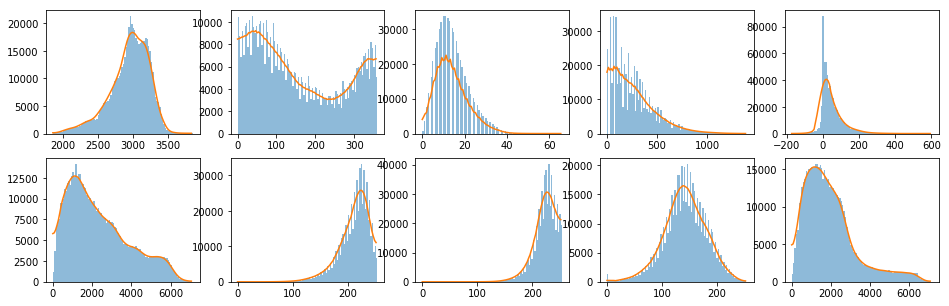

In [5]:
def smooth(x,beta):
    """ kaiser window smoothing """
    window_len=11
    # extending the data at beginning and at the end
    # to apply the window at the borders
    s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.kaiser(window_len,beta)
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y[5:len(y)-5]

fig = plt.figure(figsize=(16, 5))
layout = (2, 5)
gs = GridSpec(*layout)
axes = [plt.subplot(gs[np.unravel_index(i, layout)]) for i in range(10)]

for i in range(10):
    ax = axes[i]
    hist, bin_edges, _ = ax.hist(data[column_names[i]], bins=100, alpha=0.5)
    
    smoothed_hist = smooth(hist, 2)
    ax.plot(bin_edges[:-1], smoothed_hist)
plt.show()



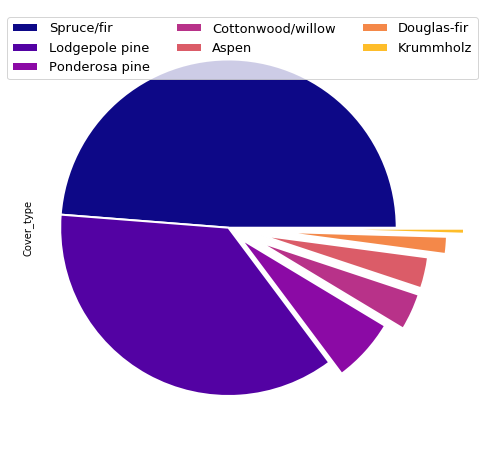

[0.48759922 0.36460521 0.06153746 0.03530048 0.02989095 0.01633873
 0.00472796]


In [159]:
cmap = plt.cm.get_cmap('plasma')
class_colours = np.array([cmap(i) for i in np.arange(7)/7])

fig = plt.figure(figsize=(8, 8))
data['Cover_type'].value_counts().plot(
    kind='pie', explode=(0, 0, 0.1, 0.2, 0.2, 0.3, 0.4),
    wedgeprops={'linewidth':2, 'edgecolor': 'w'}, labels=None,
    colors=class_colours, fontsize=16
)
plt.axis('equal')
plt.legend(labels=cover_types, fontsize=13, ncol=3)
#fig.savefig('covertypes_pie_chart.svg')
plt.show()

print(data['Cover_type'].value_counts().values / 581012)

In [7]:
column_correlations = data[column_names[:10]].corr(method='pearson')

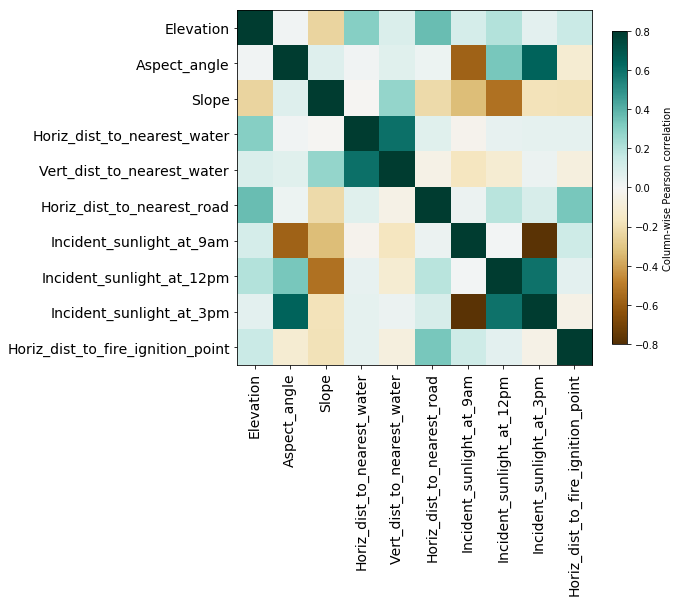

In [8]:
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(column_correlations, cmap=plt.cm.BrBG,
          vmin=-0.8, vmax=0.8, interpolation='nearest')
cbar = plt.colorbar(im, fraction=0.04)
cbar.set_label('Column-wise Pearson correlation')
ticks = np.arange(0, 10, 1); labels = np.array(column_names[:10])[ticks]
ax.set_xticks(ticks); ax.set_yticks(ticks)
ax.set_yticklabels(labels, fontsize=14)
ax.set_xticklabels(labels, fontsize=14, rotation=90)

plt.show()

## Extract features and labels from dataframe

In [39]:
features = data[column_names[:-1]].values
labels = data['Cover_type'].values - 1
print(features.shape, labels.shape)

(581012, 54) (581012,)


In [133]:
# Baseline accuracy
print(format_classifier_performance(construct_confusion_matrix(labels, np.ones_like(labels))))


    Overall Accuracy: 0.488
    Mean Precision:   0.070 +/- 0.171
    Mean Recall:      0.143 +/- 0.350
    Mean F1 Score:    nan +/- nan
    


## How features separate classes

In [140]:
def plot_class_observations_per_feature(feature_column, name=None, bins=500):
    """
        This function counts the number of class observations for given ranges
        of feature columns. By plotting the resulting histograms, we can observe
        how features separate classes.
    """
    row_indices_split = np.array_split(feature_column.argsort(), bins)
    binned_values = np.linspace(feature_column.min(), feature_column.max(), num=bins)

    # Loop over each set of rows and count the occurrences of each
    # class
    class_counts = np.zeros((bins, 7))
    for i, row_indices in enumerate(row_indices_split):
        # Count classes for this set of observations
        classes, counts = np.unique(labels[row_indices], return_counts=True)
        class_counts[i, classes] = counts

    feature_name = name if name is not None else ''
    fig, ax = plt.subplots(figsize=(16, 5))
    for i in range(7):
        cts = class_counts[:, i]
        ax.fill_between(binned_values, cts, 0, alpha=0.2)
        ax.plot(binned_values, cts, alpha=0.8, label=cover_types[i])
        #ax.bar(binned_values, cts, alpha=0.75)
    ax.set_ylabel('Class counts')
    ax.set_xlabel(feature_name)
    ax.set_title('Number of class observations per feature: ' + feature_name)
    ax.legend(ncol=4)
    return fig, ax

## Class separation through continuous variables

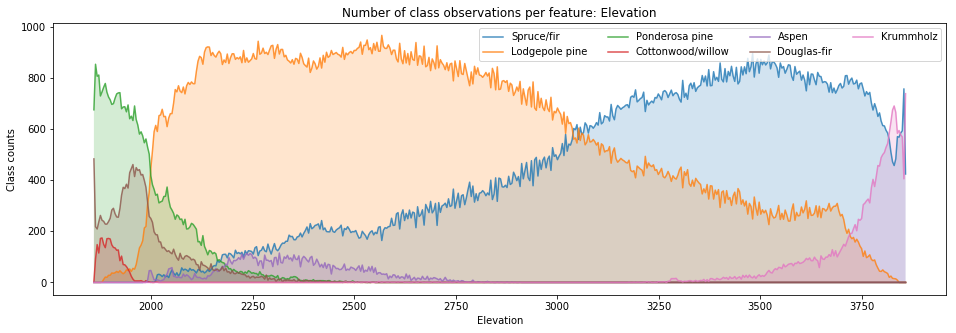

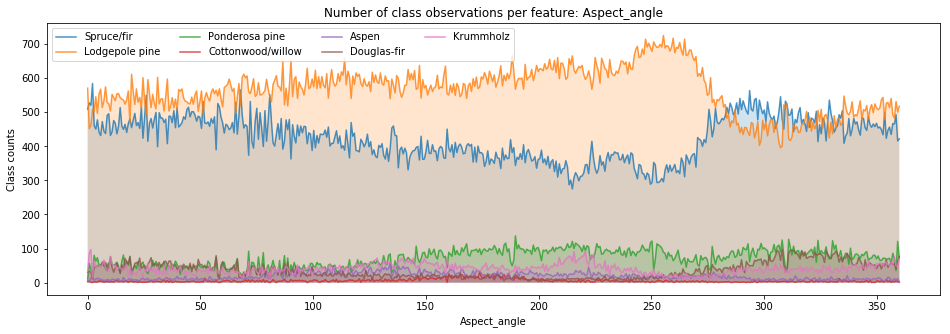

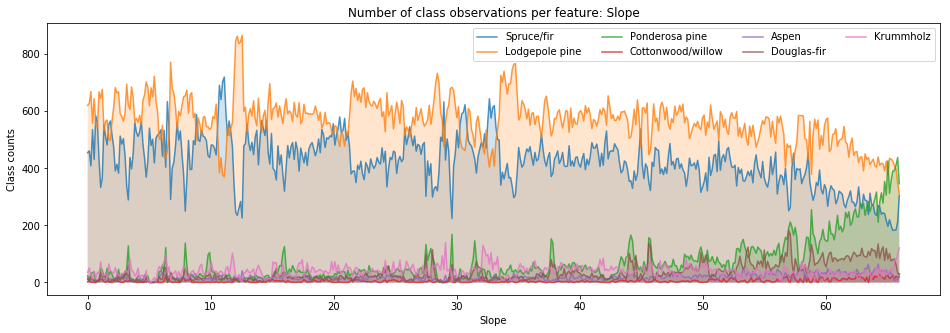

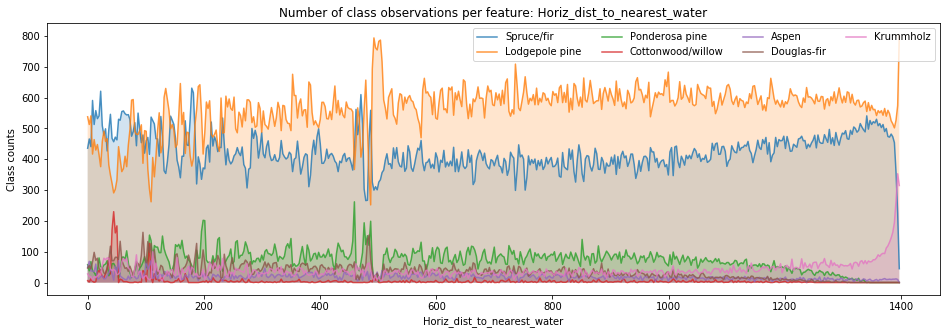

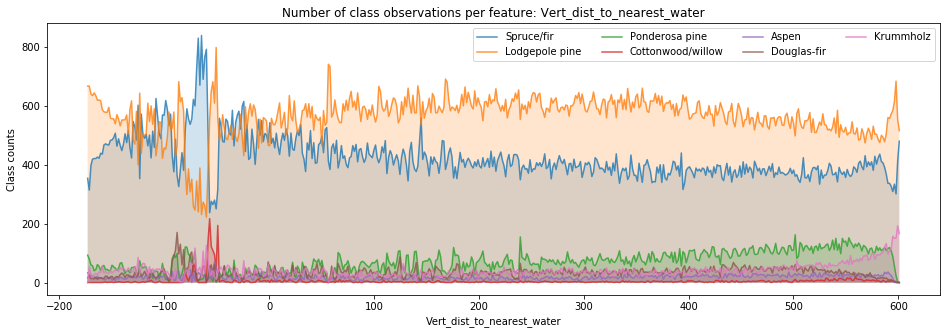

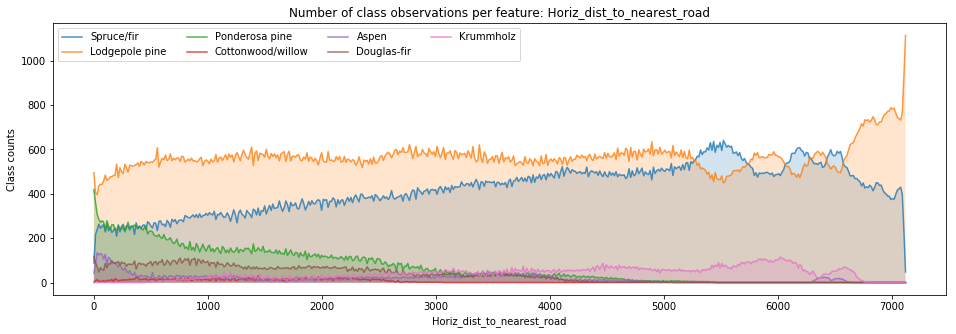

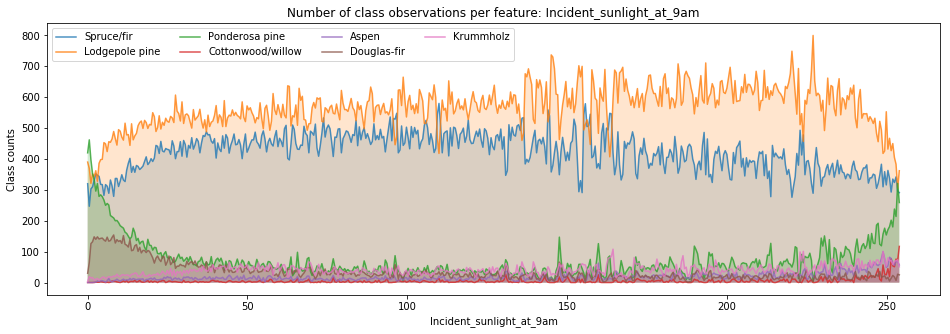

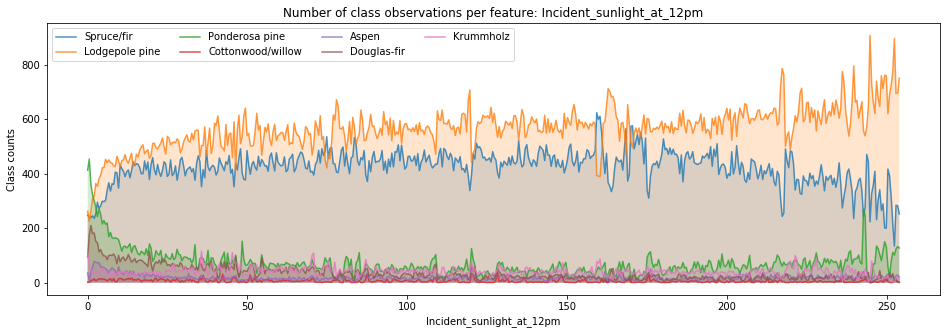

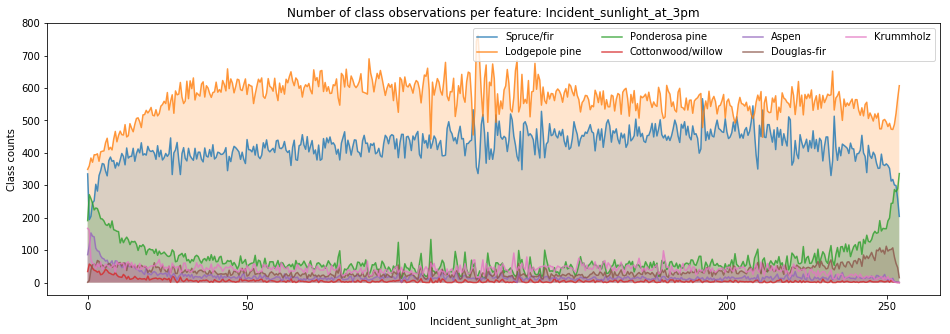

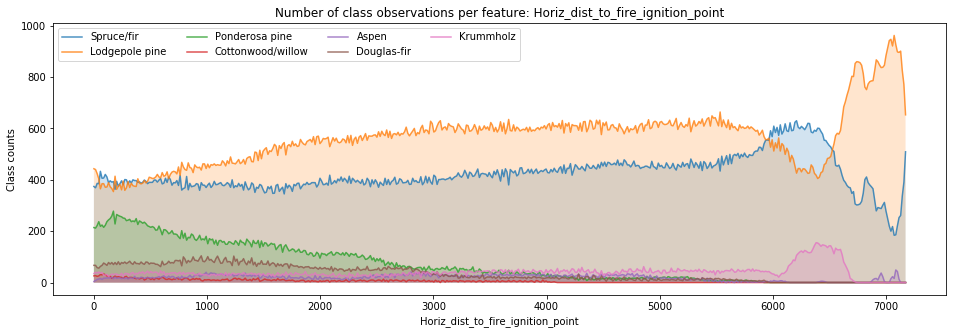

In [141]:
for feature_name in column_names[:10]:
    feature_column = data[feature_name].values
    plot_class_observations_per_feature(feature_column, name=feature_name)
plt.show()

## Create single columns for soil type and wilderness areas

In [128]:
soil_types = data[['Soil_type_{}'.format(i) for i in range(40)]].values
wilderness_areas = wilderness_columns = data[['Wilderness_area_{}'.format(i) for i in range(4)]].values

# Both soil types and wilderness areas consist of only ones and zeros (binary columns)
print(np.unique(soil_types))
print(np.unique(wilderness_areas))

# Assert that the column values are mutually exclusive
soil_sum = np.sum(soil_types, axis=1)
print(np.unique(soil_sum, return_counts=True))

wild_sum = np.sum(wilderness_areas, axis=1)
print(np.unique(wild_sum, return_counts=True))

# Create new columns for both soil type and wilderness areas with indicator 
# numbers from 0-4 and 0-40 respectively
wilderness_areas_new = np.argmax(wilderness_areas, axis=1)
soil_types_new = np.argmax(soil_types, axis=1)

features_compressed = np.hstack((features[:, :10], # Continuous variables
                                 wilderness_areas_new[:, np.newaxis], # The new wilderness areas
                                 soil_types_new[:, np.newaxis], # The new soil types
))


[0 1]
[0 1]
(array([1]), array([581012]))
(array([1]), array([581012]))


## Class separation by soil and wilderness areas

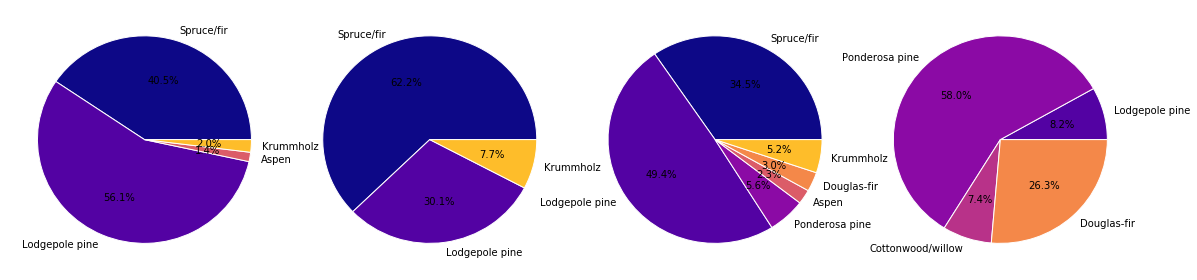

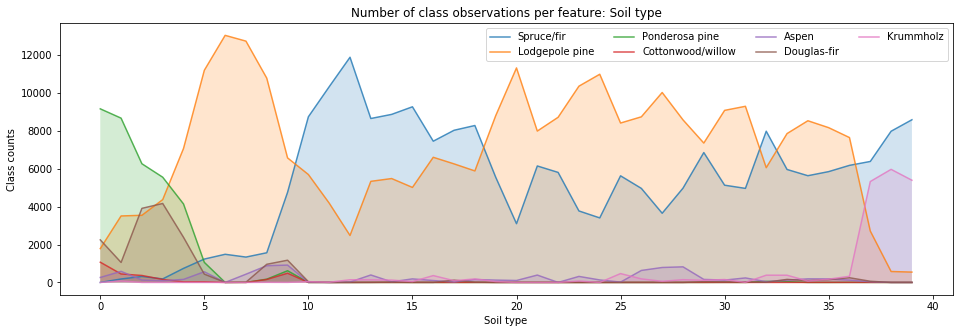

In [129]:
labels_per_area = [labels[np.where(w_col == 1)] for w_col in wilderness_areas.T]
fig = plt.figure(figsize=(16, 4))
gs = GridSpec(1, 4)

axes = [plt.subplot(gs[0, i]) for i in range(4)]

for i, ax in enumerate(axes):
    classes, class_counts = np.unique(labels_per_area[i], return_counts=True)
    ax.pie(class_counts, labels=np.array(cover_types)[classes], autopct='%1.1f%%',
        colors=class_colours[classes],
                 wedgeprops={'linewidth':1, 'edgecolor': 'w'})
    h, l = ax.get_legend_handles_labels()
plt.tight_layout()
plt.show()

plot_class_observations_per_feature(soil_types_new, 'Soil type', bins=40)
plt.show()

## Feature engineering

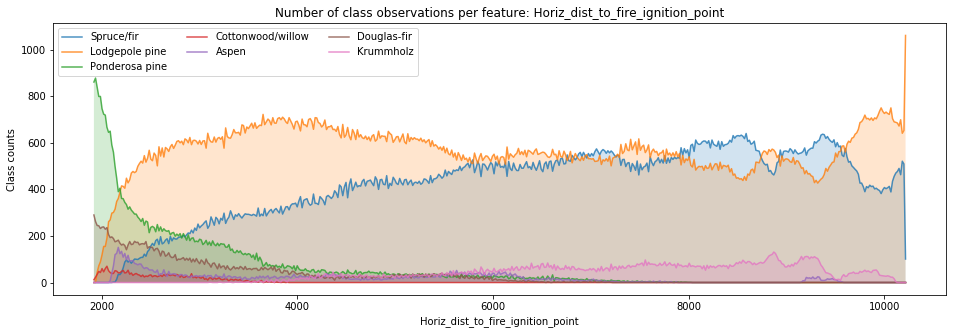

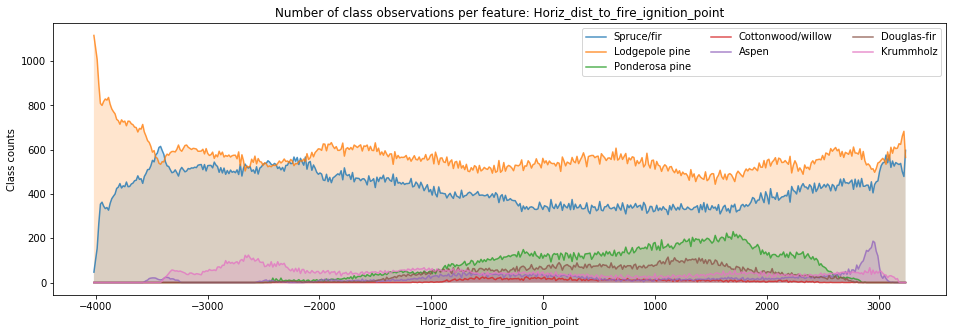

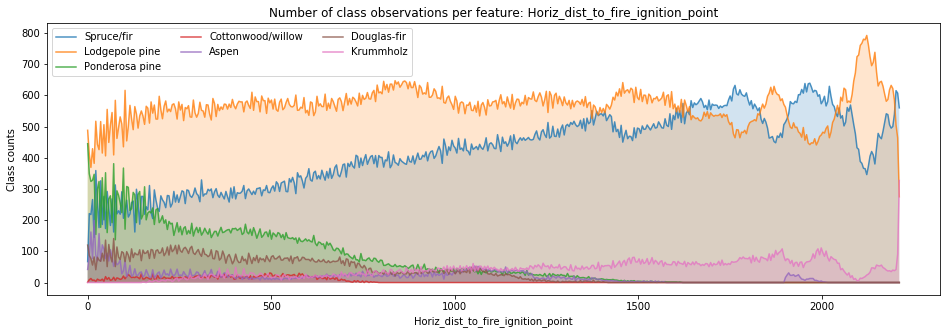

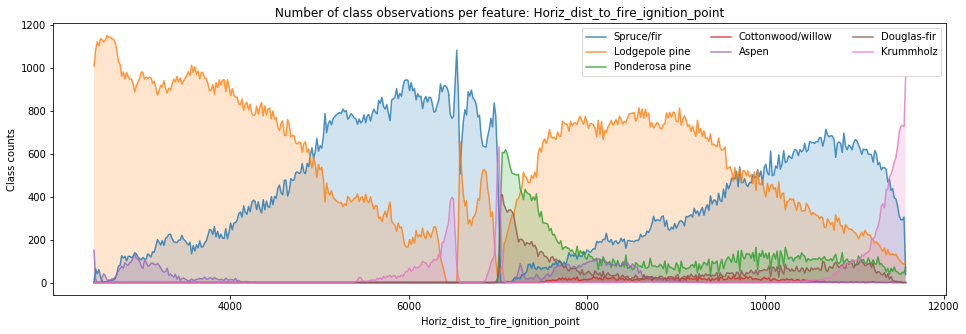

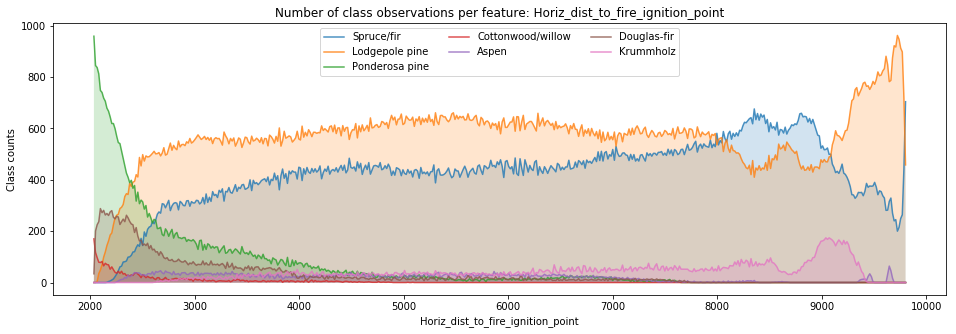

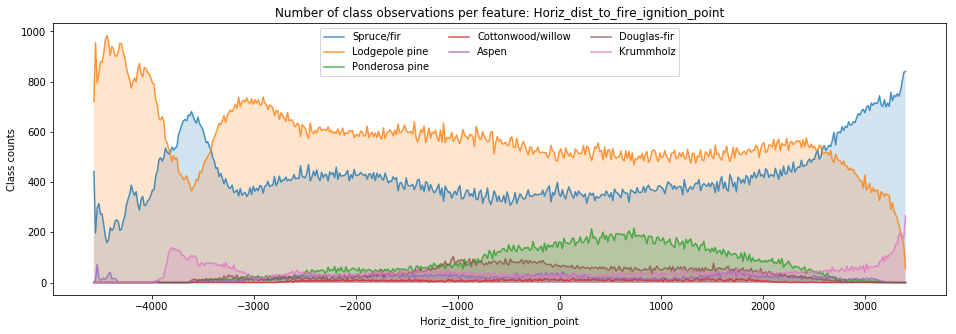

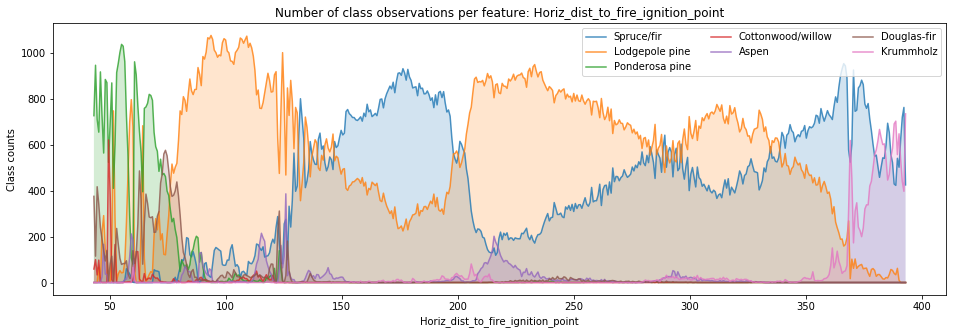

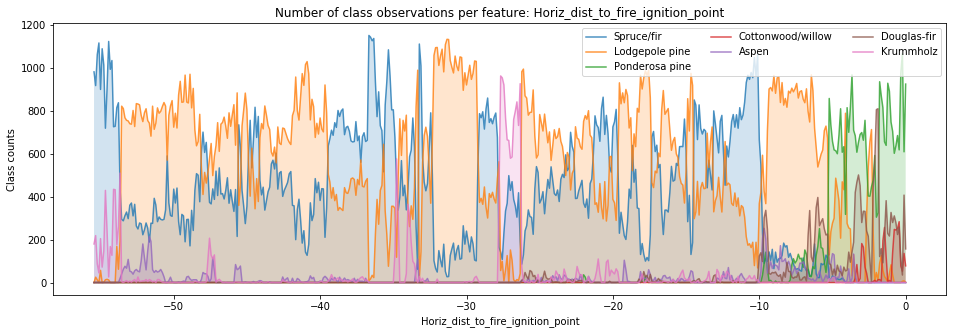

In [117]:
elevation_plus_road_dist = data['Elevation'].values  + data['Horiz_dist_to_nearest_road'].values
elevation_minus_road_dist = data['Elevation'].values  - data['Horiz_dist_to_nearest_road'].values

elevation_road_dist_harm_mean = \
    data['Elevation'].values * data['Horiz_dist_to_nearest_road'].values / elevation_plus_road_dist

elevation_plus_fire_dist = data['Elevation'].values + data['Horiz_dist_to_fire_ignition_point'].values
elevation_minus_fire_dist = data['Elevation'].values - data['Horiz_dist_to_fire_ignition_point'].values

elevation_times_soil = np.sqrt(data['Elevation'] * (soil_types_new + 1))
elevation_times_warea = data['Elevation'] * (wilderness_areas_new + 1)
warea_times_soil = np.log((wilderness_areas_new+1)/4) * (soil_types_new + 1)

new_features = [
    elevation_plus_road_dist,
    elevation_minus_road_dist,
    elevation_road_dist_harm_mean,
    elevation_times_warea,
    elevation_plus_fire_dist,
    elevation_minus_fire_dist,
    elevation_times_soil,
    warea_times_soil
]

for feature_column in new_features:
    plot_class_observations_per_feature(feature_column)
plt.show()

features_engineered = np.hstack([f[:, np.newaxis] for f in new_features])
full_features = np.hstack((features_compressed, features_engineered))

## Outlier removal

In [35]:
# Remove data that lies outside 10-90% (or some other range)
numeric_data = data[column_names[:10]]
bool_array = (
    ( numeric_data > numeric_data.quantile(1e-4) )
    & ( numeric_data < numeric_data.quantile(1-1e-4) ).values
)
rows_to_keep = np.all(bool_array, axis=1)

In [36]:
print(bool_array.shape)
reduced_data = numeric_data.values[rows_to_keep, :]
print(reduced_data.shape) #542401, 10

(581012, 10)
(540300, 10)


In [41]:
print(features.shape, labels.shape)

#features = features[rows_to_keep]
#labels = labels[rows_to_keep]

print(features.shape, labels.shape)

(581012, 10) (581012,)
(581012, 10) (581012,)


## RandomForest classification

In [156]:
tic = time.time()
cms = cross_validate_classifier(RandomForestClassifier,
                               full_features, labels,
                                kfold=2, kwargs={'n_estimators': 10, 'n_jobs': 6, 'bootstrap': False,
                                                'criterion': 'entropy'})
toc = time.time() - tic
print('Ran Classifier in {:.2f} s.'.format(toc))

Ran Classifier in 23.36 s.


In [155]:
print(format_classifier_performance(np.mean(cms, axis=0)))
#plot_confusion_matrix(cms)
df_total, df_class, df_conf = metrics_wrapper(np.mean(cms, axis=0), cover_types, do_display=True)


    Overall Accuracy: 0.967
    Mean Precision:   0.952 +/- 0.021
    Mean Recall:      0.928 +/- 0.050
    Mean F1 Score:    0.940 +/- 0.035
    
Average/overall metrics:


,Average F-Meas,Average Precision,Average Recall,Overall Accuracy
Class-Averaged or Overall:,0.94,0.95,0.93,0.97


Class-specific metrics:


,Class,F-Meas,Precision,Recall
Confusion Matrix Index,,,,
0,Spruce/fir,0.97,0.97,0.97
1,Lodgepole pine,0.97,0.97,0.97
2,Ponderosa pine,0.96,0.95,0.97
3,Cottonwood/willow,0.89,0.92,0.87
4,Aspen,0.89,0.94,0.85
5,Douglas-fir,0.93,0.94,0.91
6,Krummholz,0.97,0.98,0.96


Confusion matrix (yellow = col max; red = row max):


Predicted,0,1,2,3,4,5,6
Actual,,,,,,,
0,20547.5,595,0.5,0,7.5,1.5,32
1,645,27582.5,33,0,38.5,26.5,5.5
2,0,44.5,3456.5,12.5,4,57.5,0
3,0,0,29.5,238.5,0,7,0
4,10.5,124.5,10,0,802,2,0
5,0.5,38.5,108.5,9.5,2,1578,0
6,66.5,10.5,0,0,0,0,1974


## RandomForest with full dataset (~95%)

In [26]:
# There is a slight increase when removing a fraction of 1e-6 compared to 1e-5 (and higher) and the full dataset.
# 0.00001
#Overall Accuracy: 0.943
#Mean Precision:   0.942 +/- 0.016
#Mean Recall:      0.865 +/- 0.092
#Mean F1 Score:    0.899 +/- 0.053

# 0.000001
#Overall Accuracy: 0.944
#   Mean Precision:   0.944 +/- 0.018
#Mean Recall:      0.874 +/- 0.085
#   Mean F1 Score:    0.905 +/- 0.049

# Full
#Overall Accuracy: 0.941
#    Mean Precision:   0.932 +/- 0.024
#    Mean Recall:      0.873 +/- 0.084
#    Mean F1 Score:    0.900 +/- 0.052


#features = data[column_names[:1] + column_names[10:-1]].values
features_ = data[column_names[:10]].values
labels = data['Cover_type'].values - 1
print(features_.shape, labels.shape)

# interesting: PCA with 5 components gives roughly same accurarcy as full dataset
#from sklearn.decomposition import PCA
#pca = PCA(n_components=5, whiten=True)
#features_new = pca.fit_transform(features)

#for i in range(10):
#    features[:, i] = (features[:, i] - np.min(features[:, i])) / (np.max(features[:, i]) - np.min(features[:, i]))

tic = time.time()
cms = cross_validate_classifier(RandomForestClassifier,
                               features_compressed, labels,
                                kfold=2, kwargs={'n_estimators': 10, 'n_jobs': 6}, style='random')
toc = time.time() - tic
print('Ran Classifier in {:.2f} s.'.format(toc))

(581012, 10) (581012,)
Ran Classifier in 10.22 s.


In [27]:
print(format_classifier_performance(np.mean(cms, axis=0)))
#plot_confusion_matrix(cms)
df_total, df_class, df_conf = metrics_wrapper(np.mean(cms, axis=0), cover_types, do_display=True)


    Overall Accuracy: 0.957
    Mean Precision:   0.947 +/- 0.019
    Mean Recall:      0.909 +/- 0.064
    Mean F1 Score:    0.927 +/- 0.040
    
Average/overall metrics:


,Average F-Meas,Average Precision,Average Recall,Overall Accuracy
Class-Averaged or Overall:,0.93,0.95,0.91,0.96


Class-specific metrics:


,Class,F-Meas,Precision,Recall
Confusion Matrix Index,,,,
0,Spruce/fir,0.96,0.96,0.96
1,Lodgepole pine,0.96,0.96,0.97
2,Ponderosa pine,0.95,0.94,0.96
3,Cottonwood/willow,0.88,0.92,0.84
4,Aspen,0.86,0.94,0.79
5,Douglas-fir,0.91,0.94,0.89
6,Krummholz,0.97,0.98,0.95


Confusion matrix (yellow = col max; red = row max):


Predicted,0,1,2,3,4,5,6
Actual,,,,,,,
0,20385.5,783.5,0.5,0,4.5,2.5,35
1,838.5,27258,53,0.5,37,30.5,7
2,1,55.5,3446,11,4,65.5,0
3,0,0,38,250,0,8.5,0
4,19,172,9,0,765,2,0
5,2.5,54.5,125.5,11,1,1574.5,0
6,89.5,9.5,0,0,0.5,0,1951


## Scan parameter of the RandomForestClassifier

In [84]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=5, whiten=True)
#features_new = pca.fit_transform(features)

def scan_parameter(parameter, parameter_values, kwargs=None):
    conf_matrices = []
    run_times = []
    if kwargs is None:
        kwargs = {}
    for param_val in parameter_values:
        kwargs[parameter] = param_val
        tic = time.time()
        cms = cross_validate_classifier(RandomForestClassifier,
                                   full_features, labels,
                                    kfold=2, kwargs=kwargs, style='prop')
        toc = time.time() - tic
        print('Ran Classifier in {:.2f} s.'.format(toc))
        run_times.append(toc)
        conf_matrices.append(np.mean(cms, axis=0))
    return conf_matrices, run_times

def plot_accuracies_and_runtime(conf_matrices, run_times, parameter, parameter_values, alias=None):
    accuracies = []
    for cm in conf_matrices:
        df_total, df_class, df_conf = metrics_wrapper(cm, cover_types, do_display=False)
        accuracies.append(df_total['Overall Accuracy'][0])

    fig, ax1 = plt.subplots(figsize=(16, 4))
    ax1.plot(parameter_values, accuracies, 'o-')
    ax2 = ax1.twinx()
    ax2.plot(parameter_values, run_times, 'ks-', alpha=0.75, mfc='none')
    ax1.set_xlabel(alias if alias is not None else parameter)
    ax1.set_ylabel('Overall Accuracy')
    ax2.set_ylabel('Runtime (s)')
    plt.show()
    print('Accuracies: ' + ',  '.join(['{:.2f}'.format(a) for a in accuracies]))

## Number of estimators

Ran Classifier in 5.40 s.
Ran Classifier in 8.37 s.
Ran Classifier in 14.99 s.
Ran Classifier in 25.28 s.
Ran Classifier in 38.16 s.
Ran Classifier in 62.71 s.
Ran Classifier in 74.76 s.
Ran Classifier in 99.07 s.
Ran Classifier in 123.99 s.


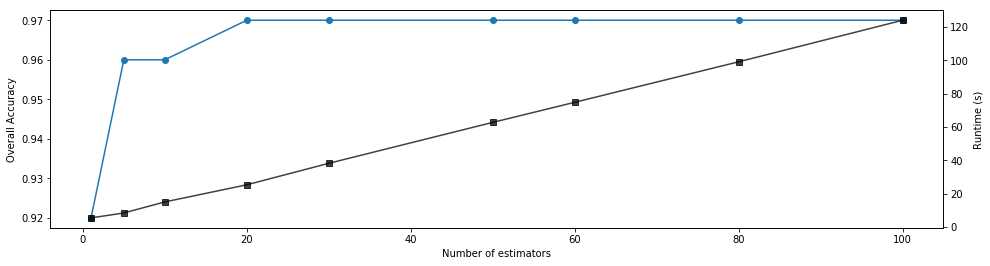

Accuracies: 0.92,  0.96,  0.96,  0.97,  0.97,  0.97,  0.97,  0.97,  0.97


In [85]:
parameter = 'n_estimators'
parameter_values = [1, 5, 10, 20, 30, 50, 60, 80, 100]
confs_1, run_times_1 = scan_parameter(parameter, parameter_values, kwargs={'n_jobs': 6})
plot_accuracies_and_runtime(confs_1, run_times_1, 
                            parameter, parameter_values, 'Number of estimators')

## Number of features for each split decision

Ran Classifier in 11.28 s.
Ran Classifier in 15.58 s.
Ran Classifier in 25.44 s.
Ran Classifier in 36.40 s.
Ran Classifier in 47.35 s.
Ran Classifier in 57.70 s.
Ran Classifier in 69.21 s.
Ran Classifier in 81.09 s.
Ran Classifier in 88.71 s.


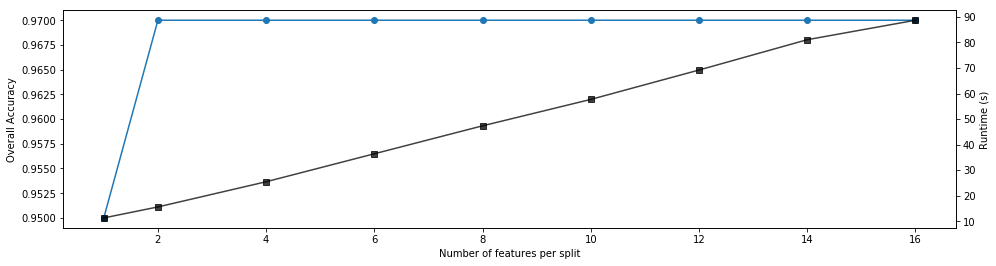

Accuracies: 0.95,  0.97,  0.97,  0.97,  0.97,  0.97,  0.97,  0.97,  0.97


In [86]:
parameter = 'max_features'
parameter_values = [1, 2, 4, 6, 8, 10, 12, 14, 16]#[1, 2, 5, 7, 10, 15, 20, 30, 40, 54]
confs_2, run_times_2 = scan_parameter(parameter, parameter_values,
                       kwargs={'n_jobs': 6, 'n_estimators': 20})
plot_accuracies_and_runtime(confs_2, run_times_2, parameter, parameter_values, 'Number of features per split')

## Maximum tree depth

Ran Classifier in 11.15 s.
Ran Classifier in 17.40 s.
Ran Classifier in 24.16 s.
Ran Classifier in 24.51 s.
Ran Classifier in 25.25 s.
Ran Classifier in 25.80 s.
Ran Classifier in 25.61 s.
Ran Classifier in 25.05 s.


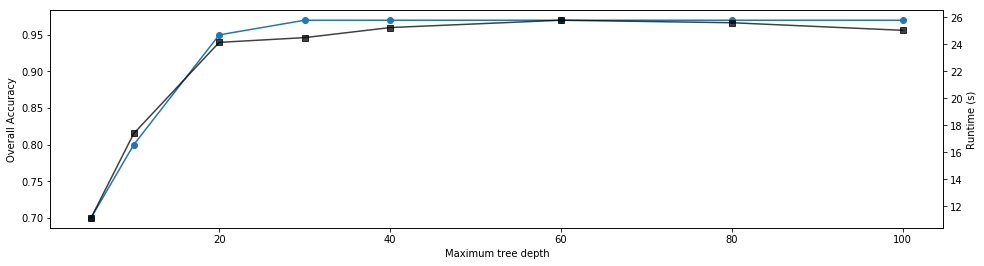

Accuracies: 0.70,  0.80,  0.95,  0.97,  0.97,  0.97,  0.97,  0.97


In [87]:
parameter = 'max_depth'
parameter_values = [5, 10, 20, 30, 40, 60, 80, 100]
confs_3, run_times_3 = scan_parameter(parameter, parameter_values,
                       kwargs={'n_jobs': 6, 'n_estimators': 20})
plot_accuracies_and_runtime(confs_3, run_times_3, parameter, parameter_values, 'Maximum tree depth')

## Minimum impurity decrease

Ran Classifier in 18.07 s.
Ran Classifier in 16.90 s.
Ran Classifier in 14.20 s.
Ran Classifier in 9.34 s.


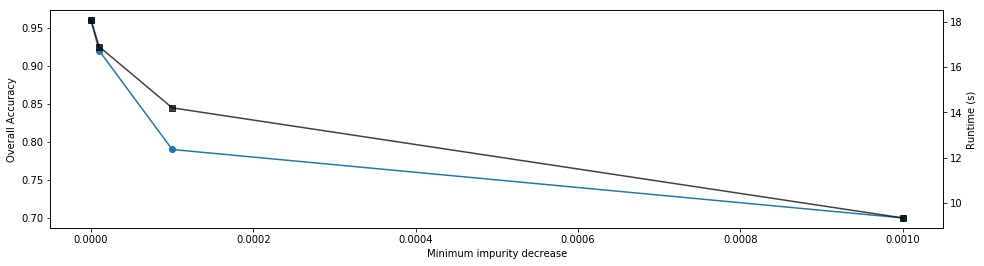

Accuracies: 0.96,  0.92,  0.79,  0.70


In [55]:
parameter = 'min_impurity_decrease'
parameter_values = [0, 1e-5, 1e-4, 1e-3]
confs_4, run_times_4 = scan_parameter(parameter, parameter_values,
                       kwargs={'n_jobs': 6, 'n_estimators': 20})
plot_accuracies_and_runtime(confs_4, run_times_4, parameter, parameter_values, 'Minimum impurity decrease')

## Final, optimised results for the RandomForestClassifier

In [113]:
tic = time.time()
cms = cross_validate_classifier(RandomForestClassifier,
                               full_features, labels,
                                kfold=2, kwargs={'n_estimators': 60, 'n_jobs': 6, 'max_depth': 40,
                                                 'max_features': 12, 'min_impurity_decrease': 0})
toc = time.time() - tic
print('Ran Classifier in {:.2f} s.'.format(toc))

Ran Classifier in 192.72 s.


In [114]:
print(format_classifier_performance(np.mean(cms, axis=0)))
#plot_confusion_matrix(cms)
df_total, df_class, df_conf = metrics_wrapper(np.mean(cms, axis=0), cover_types, do_display=True)


    Overall Accuracy: 0.973
    Mean Precision:   0.958 +/- 0.022
    Mean Recall:      0.944 +/- 0.038
    Mean F1 Score:    0.951 +/- 0.029
    
Average/overall metrics:


,Average F-Meas,Average Precision,Average Recall,Overall Accuracy
Class-Averaged or Overall:,0.95,0.96,0.94,0.97


Class-specific metrics:


,Class,F-Meas,Precision,Recall
Confusion Matrix Index,,,,
0,Spruce/fir,0.97,0.98,0.97
1,Lodgepole pine,0.98,0.97,0.98
2,Ponderosa pine,0.97,0.96,0.97
3,Cottonwood/willow,0.9,0.92,0.89
4,Aspen,0.91,0.94,0.88
5,Douglas-fir,0.95,0.96,0.94
6,Krummholz,0.97,0.98,0.97


Confusion matrix (yellow = col max; red = row max):


Predicted,0,1,2,3,4,5,6
Actual,,,,,,,
0,20594,547,0.5,0,6,1.5,35
1,448,27779,34,0,47.5,16,6.5
2,0.5,42.5,3477,13,3,39,0
3,0,0,22.5,245,0,7.5,0
4,8,90.5,9.5,0,838.5,2.5,0
5,1,27.5,67.5,9.5,0.5,1631,0
6,61,8.5,0,0,0.5,0,1981
